In [1]:
import numpy as np 

def get_uniform_mass_bins(probs, n_bins):
    assert(probs.size >= n_bins), "Fewer points than bins"
    
    probs_sorted = np.sort(probs)

    # split probabilities into groups of approx equal size
    groups = np.array_split(probs_sorted, n_bins)
    bin_edges = list()
    bin_upper_edges = list()

    for cur_group in range(n_bins-1):
        bin_upper_edges += [max(groups[cur_group])]
    bin_upper_edges += [np.inf]

    return np.array(bin_upper_edges)

def bin_points(scores, bin_edges):
    assert(bin_edges is not None), "Bins have not been defined"
    scores = scores.squeeze()
    assert(np.size(scores.shape) < 2), "scores should be a 1D vector or singleton"
    scores = np.reshape(scores, (scores.size, 1))
    bin_edges = np.reshape(bin_edges, (1, bin_edges.size))
    return np.sum(scores > bin_edges, axis=1)

def bin_points_uniform(x, n_bins):
    x = x.squeeze()
    bin_upper_edges = get_uniform_mass_bins(x, n_bins)
    return np.sum(x.reshape((-1, 1)) > bin_upper_edges, axis=1)

def nudge(matrix, delta):
    return((matrix + np.random.uniform(low=0,
                                       high=delta,
                                       size=(matrix.shape)))/(1+delta))

class identity():
    def predict_proba(self, x):
        return x
    def predict(self, x):
        return np.argmax(x, axis=1)

In [2]:
import numpy as np

class HB_binary(object):
    def __init__(self, n_bins=15):
        ### Hyperparameters
        self.delta = 1e-10
        self.n_bins = n_bins

        ### Parameters to be learnt 
        self.bin_upper_edges = None
        self.mean_pred_values = None
        self.num_calibration_examples_in_bin = None

        ### Internal variables
        self.fitted = False
        
    def fit(self, y_score, y):
        assert(self.n_bins is not None), "Number of bins has to be specified"
        y_score = y_score.squeeze()
        y = y.squeeze()
        assert(y_score.size == y.size), "Check dimensions of input matrices"
        assert(y.size >= self.n_bins), "Number of bins should be less than the number of calibration points"
        
        ### All required (hyper-)parameters have been passed correctly
        ### Uniform-mass binning/histogram binning code starts below

        # delta-randomization
        y_score = nudge(y_score, self.delta)

        # compute uniform-mass-bins using calibration data
        self.bin_upper_edges = get_uniform_mass_bins(y_score, self.n_bins)

        # assign calibration data to bins
        bin_assignment = bin_points(y_score, self.bin_upper_edges)

        # compute bias of each bin 
        self.num_calibration_examples_in_bin = np.zeros([self.n_bins, 1])
        self.mean_pred_values = np.empty(self.n_bins)
        for i in range(self.n_bins):
            bin_idx = (bin_assignment == i)
            self.num_calibration_examples_in_bin[i] = sum(bin_idx)

            # nudge performs delta-randomization
            if (sum(bin_idx) > 0):
                self.mean_pred_values[i] = nudge(y[bin_idx].mean(),
                                                 self.delta)
            else:
                self.mean_pred_values[i] = nudge(0.5, self.delta)

        # check that my code is correct
        assert(np.sum(self.num_calibration_examples_in_bin) == y.size)

        # histogram binning done
        self.fitted = True

    def predict_proba(self, y_score):
        assert(self.fitted is True), "Call HB_binary.fit() first"
        y_score = y_score.squeeze()

        # delta-randomization
        y_score = nudge(y_score, self.delta)
        
        # assign test data to bins
        y_bins = bin_points(y_score, self.bin_upper_edges)
            
        # get calibrated predicted probabilities
        y_pred_prob = self.mean_pred_values[y_bins]
        return y_pred_prob

class HB_toplabel(object):
    def __init__(self, points_per_bin=50):
        ### Hyperparameters
        self.points_per_bin = points_per_bin

        ### Parameters to be learnt 
        self.hb_binary_list = []
        
        ### Internal variables
        self.num_classes = None
    
    def fit(self, pred_mat, y):
        assert(self.points_per_bin is not None), "Points per bins has to be specified"
        assert(np.size(pred_mat.shape) == 2), "Prediction matrix should be 2 dimensional"
        y = y.squeeze()
        assert(pred_mat.shape[0] == y.size), "Check dimensions of input matrices"
        self.num_classes = pred_mat.shape[1]
        assert(np.min(y) >= 1 and np.max(y) <= self.num_classes), "Labels should be numbered 1 ... L, where L is the number of columns in the prediction matrix"
        
        top_score = np.max(pred_mat, axis=1).squeeze()
        pred_class = (np.argmax(pred_mat, axis=1)+1).squeeze()

        for l in range(1, self.num_classes+1, 1):
            pred_l_indices = np.where(pred_class == l)
            n_l = np.size(pred_l_indices)

            bins_l = np.floor(n_l/self.points_per_bin).astype('int')
            if(bins_l == 0):
               self.hb_binary_list += [identity()]
               print("Predictions for class {:d} not recalibrated since fewer than {:d} calibration points were predicted as class {:d}.".format(l, self.points_per_bin, l))
            else:
                hb = HB_binary(n_bins = bins_l)
                hb.fit(top_score[pred_l_indices], y[pred_l_indices] == l)
                self.hb_binary_list += [hb]
        
        # top-label histogram binning done
        self.fitted = True

    def predict_proba(self, pred_mat):
        assert(self.fitted is True), "Call HB_binary.fit() first"
        assert(np.size(pred_mat.shape) == 2), "Prediction matrix should be 2 dimensional"
        assert(self.num_classes == pred_mat.shape[1]), "Number of columns of prediction matrix do not match number of labels"
        
        top_score = np.max(pred_mat, axis=1).squeeze()
        pred_class = (np.argmax(pred_mat, axis=1)+1).squeeze()

        n = pred_class.size
        pred_top_score = np.zeros((n))
        for i in range(n):
            pred_top_score[i] = self.hb_binary_list[pred_class[i]-1].predict_proba(top_score[i])

        return pred_top_score

    def fit_top(self, top_score, pred_class, y):
        assert(self.points_per_bin is not None), "Points per bins has to be specified"

        top_score = top_score.squeeze()
        pred_class = pred_class.squeeze()
        y = y.squeeze()

        assert(min(np.min(y), np.min(pred_class)) >= 1), "Labels should be numbered 1 ... L, use HB_binary for a binary problem"
        assert(top_score.size == y.size), "Check dimensions of input matrices"
        assert(pred_class.size == y.size), "Check dimensions of input matrices"
        assert(y.size >= self.n_bins), "Number of bins should be less than the number of calibration points"

        self.num_classes = max(np.max(y), np.max(pred_class))
        
        for l in range(1, self.num_classes+1, 1):
            pred_l_indices = np.where(pred_class == l)
            n_l = np.size(pred_l_indices)

            bins_l = np.floor(n_l/self.points_per_bin).astype('int')
            if(bins_l == 0):
               self.hb_binary_list += [identity()]
               print("Predictions for class {:d} not recalibrated since fewer than {:d} calibration points were predicted as class {:d}".format(self.points_per_bin, l))
            else:
                hb = HB_binary(n_bins = bins_l)
                hb.fit(top_score[pred_l_indices], y[pred_l_indices] == l)
                self.hb_binary_list += [hb]
        
        # top-label histogram binning done
        self.fitted = True

    def predict_proba_top(self, top_score, pred_class):
        assert(self.fitted is True), "Call HB_binary.fit() first"
        top_score = top_score.squeeze()
        pred_class = pred_class.squeeze()
        assert(top_score.size == pred_class.size), "Check dimensions of input matrices"
        assert(np.min(pred_class) >= 1 and np.min(pred_class) <= self.num_classes), "Some of the predicted labels are not in the range of labels seen while calibrating"
        n = pred_class.size
        pred_top_score = np.zeros((n))
        for i in range(n):
            pred_top_score[i] = self.hb_binary_list[pred_class[i]-1].predict_proba(top_score[i])

        return pred_top_score
        

In [ ]:
import csv
from collections import deque
import numpy as np
import logging
from capymoa.base import MOAClassifier
from moa.classifiers.meta import StreamingRandomPatches as _MOA_SRP
from capymoa.stream import ARFFStream
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

class SSSSSStreamingRandomPatches(MOAClassifier):
    def __init__(
        self,
        schema,
        random_seed=0,
        ensemble_size=100,
        use_calibration=False,
        calibration_type="HB_toplabel",
        points_per_bin=50,
        sliding_window_size=1000,
        calibration_update_interval=100,
        accuracy_threshold=0.6,
        prune_threshold=0.5,
        **kwargs,
    ):
        super().__init__(moa_learner=_MOA_SRP, schema=schema, random_seed=random_seed, **kwargs)

        self.use_calibration = use_calibration
        self.calibration_type = calibration_type
        self.points_per_bin = points_per_bin
        self.sliding_window_size = sliding_window_size
        self.calibration_update_interval = calibration_update_interval

        self.calibration_data = {"scores": deque(maxlen=sliding_window_size), "labels": deque(maxlen=sliding_window_size)}
        self.calibration_model = None
        self.calibration_counter = 0

        self.tree_accuracies = [1.0] * ensemble_size  # Initial accuracy for all trees
        self.ensemble_weights = [1.0] * ensemble_size  # Initial weights for all trees

        if self.use_calibration:
            if self.calibration_type == "HB_toplabel":
                self.calibration_model = HB_toplabel(points_per_bin=self.points_per_bin)
            elif self.calibration_type == "HB_binary":
                self.calibration_model = HB_binary(n_bins=15)
            else:
                raise ValueError(f"Unsupported calibration type: {self.calibration_type}")

        self.accuracy_threshold = accuracy_threshold
        self.prune_threshold = prune_threshold

    def partial_fit(self, X, y, classes=None):
        super().partial_fit(X, y, classes)

        # Update tree-specific accuracies after training
        predictions = self.predict(X)
        for i, (pred, true_label) in enumerate(zip(predictions, y)):
            tree_idx = i % len(self.tree_accuracies)
            if pred == true_label:
                self.tree_accuracies[tree_idx] *= 0.9  # Weight older results less
            else:
                self.tree_accuracies[tree_idx] *= 1.1

        # Normalize tree accuracies to derive ensemble weights
        self.ensemble_weights = [1 / (1 + acc) for acc in self.tree_accuracies]
        total_weight = sum(self.ensemble_weights)
        self.ensemble_weights = [w / total_weight for w in self.ensemble_weights]

        # Prune or replace low-performing trees
        self.prune_or_replace_trees()

        if self.use_calibration:
            # Update calibration data
            y_proba = self.predict_proba(X)
            self.calibration_data["scores"].extend(y_proba)
            self.calibration_data["labels"].extend(y)

            self.calibration_counter += 1

            # Trigger recalibration if update interval is reached
            if self.calibration_counter % self.calibration_update_interval == 0:
                self.update_calibration()

    def update_calibration(self):
        """
        Perform recalibration using the sliding window data.
        """
        if len(self.calibration_data["scores"]) >= self.points_per_bin:
            scores = np.array(self.calibration_data["scores"])
            labels = np.array(self.calibration_data["labels"])

            try:
                self.calibration_model.fit(scores, labels)
                logging.info("Calibration model updated successfully.")
            except Exception as e:
                logging.error(f"Error during calibration update: {e}")

    def prune_or_replace_trees(self):
        """
        Replace or prune trees with accuracy below the threshold.
        """
        for i, accuracy in enumerate(self.tree_accuracies):
            if accuracy < self.prune_threshold:
                logging.info(f"Tree {i} replaced due to low accuracy ({accuracy:.2f}).")
                self.tree_accuracies[i] = 1.0  # Reset accuracy for the new tree
                self.ensemble_weights[i] = 1.0 / len(self.tree_accuracies)

    def predict_proba(self, X):
        base_proba = super().predict_proba(X)

        # Apply weighted contributions
        weighted_proba = np.zeros_like(base_proba)
        for i, proba in enumerate(base_proba):
            tree_weight = self.ensemble_weights[i % len(self.ensemble_weights)]
            weighted_proba[i] += proba * tree_weight

        if self.use_calibration and self.calibration_model and self.calibration_model.fitted:
            top_scores = np.max(weighted_proba, axis=1)
            top_classes = np.argmax(weighted_proba, axis=1) + 1
            return self.calibration_model.predict_proba_top(top_scores, top_classes)

        return weighted_proba

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# List of datasets to evaluate
datasets = [
    ARFFStream(path="./data/airlines.arff", class_index=-1),
    ARFFStream(path="./data/elecNormNew.arff", class_index=-1),
    ARFFStream(path="./data/internet_ads.arff", class_index=-1),
    ARFFStream(path="./data/covtype.arff", class_index=-1),
    ARFFStream(path="./data/kdd99.arff", class_index=-1),
]

def evaluate_two_methods_and_save_csv(datasets, csv_filename):
    """
    Evaluate StreamingRandomPatches and SSSSSStreamingRandomPatches on datasets
    and save results to a CSV file, also plot results.
    """
    results = []
    all_results = {}

    for dataset in datasets:
        dataset_name = dataset.__class__.__name__  # Use class name as dataset name
        print(f"Evaluating on dataset: {dataset_name}")

        # Initialize the default StreamingRandomPatches Classifier
        learner_srp = StreamingRandomPatches(
            schema=dataset.get_schema(),
            random_seed=42,
            ensemble_size=10
        )

        # Initialize the enhanced SSSSSStreamingRandomPatches Classifier
        learner_ssrp = SSSSSStreamingRandomPatches(
            schema=dataset.get_schema(),
            random_seed=42,
            ensemble_size=10,
            use_calibration=True,
            calibration_type="HB_toplabel",
            points_per_bin=50
        )

        try:
            # Perform prequential evaluation for both classifiers
            result_srp = prequential_evaluation(dataset, learner_srp)
            result_ssrp = prequential_evaluation(dataset, learner_ssrp)

            # Store results for plotting
            all_results[f"{dataset_name}_SRP"] = result_srp
            all_results[f"{dataset_name}_SSRP"] = result_ssrp

            # Extract metrics for StreamingRandomPatches
            accuracy_srp = result_srp.cumulative.accuracy()
            kappa_m_srp = result_srp.cumulative.kappa_m()
            kappa_t_srp = result_srp.cumulative.kappa_t()

            # Extract metrics for SSSSSStreamingRandomPatches
            accuracy_ssrp = result_ssrp.cumulative.accuracy()
            kappa_m_ssrp = result_ssrp.cumulative.kappa_m()
            kappa_t_ssrp = result_ssrp.cumulative.kappa_t()

            # Append results to the list
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamingRandomPatches",
                "Accuracy": accuracy_srp,
                "Kappa_M": kappa_m_srp,
                "Kappa_T": kappa_t_srp,
            })

            results.append({
                "Dataset": dataset_name,
                "Classifier": "SSSSSStreamingRandomPatches",
                "Accuracy": accuracy_ssrp,
                "Kappa_M": kappa_m_ssrp,
                "Kappa_T": kappa_t_ssrp,
            })

            print(
                f"Dataset: {dataset_name} | StreamingRandomPatches Accuracy: {accuracy_srp:.2f} | "
                f"SSSSSStreamingRandomPatches Accuracy: {accuracy_ssrp:.2f}"
            )
        except Exception as e:
            print(f"Error during evaluation on dataset {dataset_name}: {e}")

    # Save results to CSV
    with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["Dataset", "Classifier", "Accuracy", "Kappa_M", "Kappa_T"])
        writer.writeheader()
        writer.writerows(results)

    print(f"Results saved to {csv_filename}")


# Run the evaluation and save results
csv_output_file = "REAL_two_methods_evaluation_results.csv"
evaluate_two_methods_and_save_csv(datasets, csv_output_file)


In [3]:
import csv
from collections import deque
import numpy as np
import logging
from capymoa.base import MOAClassifier
from moa.classifiers.meta import StreamingRandomPatches as _MOA_SRP
from capymoa.stream import ARFFStream
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from collections import deque
import numpy as np
import logging

class StreamWiseRandomPatches(MOAClassifier):
    def __init__(
        self,
        schema,
        random_seed=0,
        ensemble_size=100,
        use_calibration=False,
        calibration_type="HB_toplabel",
        points_per_bin=50,
        sliding_window_size=1000,
        calibration_update_interval=100,
        accuracy_threshold=0.6,
        prune_threshold=0.5,
        **kwargs,
    ):
        super().__init__(moa_learner=_MOA_SRP, schema=schema, random_seed=random_seed, **kwargs)

        self.use_calibration = use_calibration
        self.calibration_type = calibration_type
        self.points_per_bin = points_per_bin
        self.sliding_window_size = sliding_window_size
        self.calibration_update_interval = calibration_update_interval

        self.calibration_data = {"scores": deque(maxlen=sliding_window_size), "labels": deque(maxlen=sliding_window_size)}
        self.calibration_model = None
        self.calibration_counter = 0

        # Accuracy and weights for weighting
        self.tree_accuracies = [1.0] * ensemble_size
        self.ensemble_weights = [1.0] * ensemble_size

        # Metrics for pruning
        self.correct_predictions = [0] * ensemble_size
        self.total_predictions = [0] * ensemble_size

        if self.use_calibration:
            if self.calibration_type == "HB_toplabel":
                self.calibration_model = HB_toplabel(points_per_bin=self.points_per_bin)
            elif self.calibration_type == "HB_binary":
                self.calibration_model = HB_binary(n_bins=15)
            else:
                raise ValueError(f"Unsupported calibration type: {self.calibration_type}")

        self.accuracy_threshold = accuracy_threshold
        self.prune_threshold = prune_threshold

    def partial_fit(self, X, y, classes=None):
        super().partial_fit(X, y, classes)

        # Update tree-specific accuracies for weighting
        predictions = self.predict(X)
        for i, (pred, true_label) in enumerate(zip(predictions, y)):
            for tree_idx in range(len(self.tree_accuracies)):  # Update all trees
                if pred == true_label:
                    self.tree_accuracies[tree_idx] *= 0.9  # Weighting: Correct prediction decreases metric
                    self.correct_predictions[tree_idx] += 1  # Pruning: Track correct predictions
                else:
                    self.tree_accuracies[tree_idx] *= 1.1  # Weighting: Incorrect prediction increases metric

                self.total_predictions[tree_idx] += 1  # Pruning: Track total predictions

        # Normalize tree accuracies to derive ensemble weights
        self.ensemble_weights = [1 / (1 + acc) for acc in self.tree_accuracies]
        total_weight = sum(self.ensemble_weights)
        self.ensemble_weights = [w / total_weight for w in self.ensemble_weights]

        # Prune or replace low-performing trees
        self.prune_or_replace_trees()

        if self.use_calibration:
            # Update calibration data
            y_proba = self.predict_proba(X)
            self.calibration_data["scores"].extend(y_proba)
            self.calibration_data["labels"].extend(y)

            self.calibration_counter += 1

            # Trigger recalibration if update interval is reached
            if self.calibration_counter % self.calibration_update_interval == 0:
                self.update_calibration()

    def update_calibration(self):
        """
        Perform recalibration using the sliding window data.
        """
        if len(self.calibration_data["scores"]) >= self.points_per_bin:
            scores = np.array(self.calibration_data["scores"])
            labels = np.array(self.calibration_data["labels"])

            try:
                self.calibration_model.fit(scores, labels)
                logging.info("Calibration model updated successfully.")
            except Exception as e:
                logging.error(f"Error during calibration update: {e}")

    def prune_or_replace_trees(self):
        """
        Replace or prune trees with true accuracy below the threshold.
        """
        for i in range(len(self.tree_accuracies)):
            # Calculate the true pruning accuracy for this tree
            if self.total_predictions[i] > 0:
                prune_accuracy = self.correct_predictions[i] / self.total_predictions[i]
            else:
                prune_accuracy = 0  # No predictions made yet

            # Prune tree if true accuracy is below the threshold
            if prune_accuracy < self.prune_threshold:
                logging.info(f"Tree {i} replaced due to low true accuracy ({prune_accuracy:.2f}).")

                # Replace the tree by resetting its metrics
                self.tree_accuracies[i] = 1.0
                self.ensemble_weights[i] = 1.0 / len(self.tree_accuracies)
                self.correct_predictions[i] = 0
                self.total_predictions[i] = 0

    def predict_proba(self, X):
        base_proba = super().predict_proba(X)

        # Apply weighted contributions
        weighted_proba = np.zeros_like(base_proba)
        for i, proba in enumerate(base_proba):
            tree_weight = self.ensemble_weights[i % len(self.ensemble_weights)]
            weighted_proba[i] += proba * tree_weight

        if self.use_calibration and self.calibration_model and self.calibration_model.fitted:
            top_scores = np.max(weighted_proba, axis=1)
            top_classes = np.argmax(weighted_proba, axis=1) + 1
            return self.calibration_model.predict_proba_top(top_scores, top_classes)

        return weighted_proba

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


In [1]:
import csv
from capymoa.stream.generator import (
    RandomTreeGenerator,
    SEA,
    HyperPlaneClassification,
    RandomRBFGenerator,
    RandomRBFGeneratorDrift,
    AgrawalGenerator,
    LEDGenerator,
    LEDGeneratorDrift,
    WaveformGenerator,
    WaveformGeneratorDrift,
    STAGGERGenerator,
    SineGenerator,
)
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import StreamingRandomPatches

# List of datasets to evaluate
datasets = [
    RandomTreeGenerator(),
    SEA(),
    HyperPlaneClassification(),
    RandomRBFGenerator(),
    RandomRBFGeneratorDrift(),
    AgrawalGenerator(),
    LEDGenerator(),
    LEDGeneratorDrift(),
    WaveformGenerator(),
    WaveformGeneratorDrift(),
    STAGGERGenerator(),
    SineGenerator(),
]

SRS10 acc = 89.40015889830508 wallclock: 5.553011417388916
SRS100 acc = 90.26747881355932 wallclock: 53.77979588508606
SSRP acc = 89.85919844632768 wallclock: 142.52247500419617


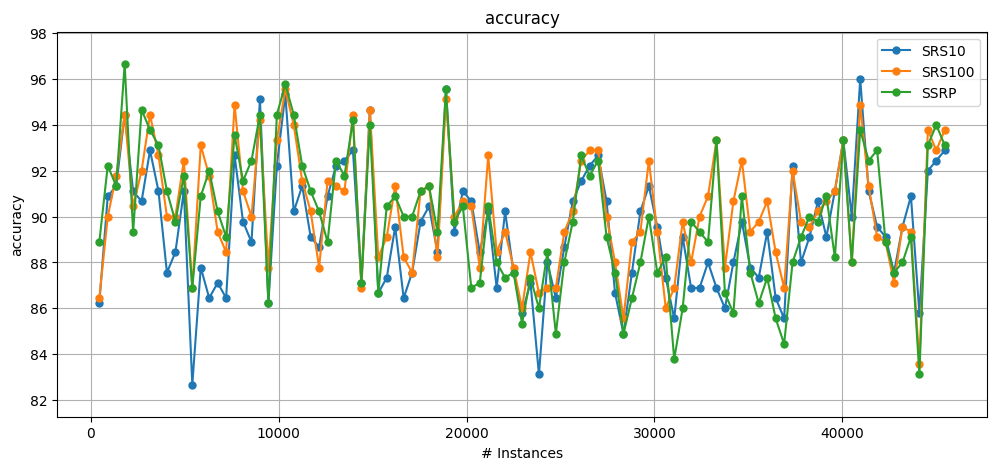

In [ ]:
from capymoa.classifier import StreamingRandomPatches
from capymoa.evaluation import prequential_evaluation
from capymoa.datasets import Electricity
from capymoa.evaluation.visualization import plot_windowed_results

elec = Electricity()

srs10 = StreamingRandomPatches(
    schema=elec.get_schema(),
    training_method="RandomSubspaces",
    max_features=0.6,
    lambda_param=1.0,
    ,
    ensemble_size=10
)

srs100 = StreamingRandomPatches(
    schema=elec.get_schema(),
    training_method="RandomSubspaces",
    max_features=0.6,
    lambda_param=1.0,
    ,
    ensemble_size=100
)
learner_ssrp = StreamWiseRandomPatches(
            schema=elec.get_schema(),
            ,
            ensemble_size=10,
            use_calibration=True,
            calibration_type="HB_toplabel",
            points_per_bin=50
        )

results_srs10 = prequential_evaluation(learner=srs10, stream=elec, window_size=450, max_instances=-1)
results_srs10.learner='SRS10'

results_srs100 = prequential_evaluation(learner=srs100, stream=elec, window_size=450, max_instances=-1)
results_srs100.learner='SRS100'

results_ssrp = prequential_evaluation(learner=learner_ssrp, stream=elec, window_size=450, max_instances=-1)
results_ssrp.learner='SSRP'


print(f'SRS10 acc = {results_srs10.cumulative.accuracy()} wallclock: {results_srs10.wallclock()}')
print(f'SRS100 acc = {results_srs100.cumulative.accuracy()} wallclock: {results_srs100.wallclock()}')
print(f'SSRP acc = {results_ssrp.cumulative.accuracy()} wallclock: {results_ssrp.wallclock()}')
# results_srp10, 
plot_windowed_results(results_srs10, results_srs100, results_ssrp,  metric="accuracy")

SRS10 acc = 89.40015889830508 wallclock: 4.696125745773315
SRS100 acc = 90.26747881355932 wallclock: 50.31807208061218
SSRP acc = 89.85919844632768 wallclock: 140.24931240081787


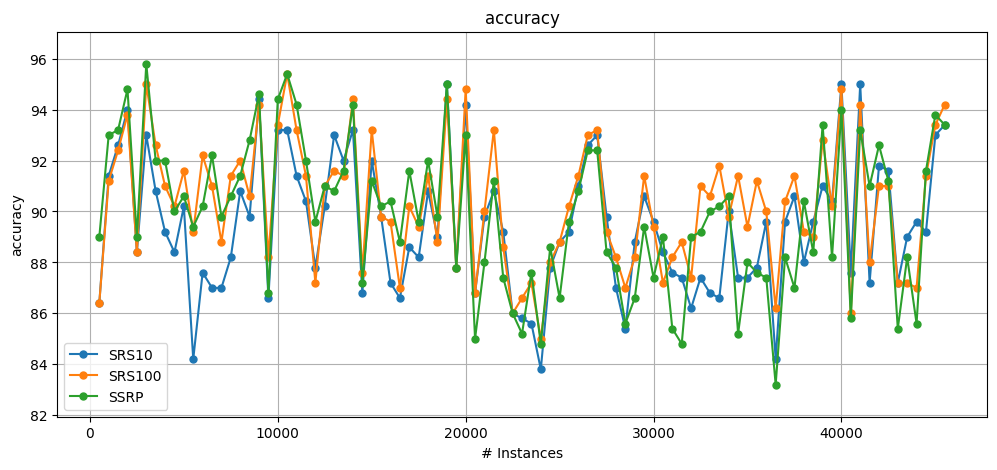

In [ ]:
from capymoa.classifier import StreamingRandomPatches
from capymoa.evaluation import prequential_evaluation
from capymoa.datasets import Electricity
from capymoa.evaluation.visualization import plot_windowed_results

elec = Electricity()

srs10 = StreamingRandomPatches(
    schema=elec.get_schema(),
    training_method="RandomSubspaces",
    max_features=0.6,
    lambda_param=1.0,
    ,
    ensemble_size=10
)

srs100 = StreamingRandomPatches(
    schema=elec.get_schema(),
    training_method="RandomSubspaces",
    max_features=0.6,
    lambda_param=1.0,
     ,
    ensemble_size=100
)
learner_ssrp = StreamWiseRandomPatches(
            schema=elec.get_schema(),
             ,
            ensemble_size=10,
            use_calibration=True,
            calibration_type="HB_toplabel",
            points_per_bin=50
        )

results_srs10 = prequential_evaluation(learner=srs10, stream=elec, window_size=500, max_instances=-1)
results_srs10.learner='SRS10'

results_srs100 = prequential_evaluation(learner=srs100, stream=elec, window_size=500, max_instances=-1)
results_srs100.learner='SRS100'

results_ssrp = prequential_evaluation(learner=learner_ssrp, stream=elec, window_size=500, max_instances=-1)
results_ssrp.learner='SSRP'


print(f'SRS10 acc = {results_srs10.cumulative.accuracy()} wallclock: {results_srs10.wallclock()}')
print(f'SRS100 acc = {results_srs100.cumulative.accuracy()} wallclock: {results_srs100.wallclock()}')
print(f'SSRP acc = {results_ssrp.cumulative.accuracy()} wallclock: {results_ssrp.wallclock()}')
# results_srp10, 
plot_windowed_results(results_srs10, results_srs100, results_ssrp,  metric="accuracy")

In [15]:
from capymoa.base import MOAClassifier
from capymoa.stream import Schema
from capymoa._utils import build_cli_str_from_mapping_and_locals
from moa.classifiers.meta import StreamingRandomPatches as _MOA_SRP
import numpy as np
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

from capymoa.base import MOAClassifier
from capymoa.stream import Schema
from capymoa._utils import build_cli_str_from_mapping_and_locals
from moa.classifiers.meta import StreamingRandomPatches as _MOA_SRP
import numpy as np
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

class EnhancedStreamingRandomPatches(MOAClassifier):
    def __init__(
        self,
        schema: Schema,
        random_seed: int = 1,
        base_learner: str = "trees.HoeffdingTree -g 50 -c 0.01",  # Added missing parameter
        ensemble_size: int = 100,
        pruning_threshold: float = 0.55,
        warning_threshold: float = 0.65,
        max_features: float = 0.6,
        training_method: str = "RandomPatches",
        lambda_param: float = 6.0,
        performance_window: int = 1000,
        **kwargs
    ):
        # Initialize MOA SRP parameters
        mapping = {
            "base_learner": "-l",
            "ensemble_size": "-s",
            "feature_mode": "-o",
            "max_features_per_ensemble_item": "-m",
            "training_method_str": "-t",
            "lambda_param": "-a",
        }

        # Handle training method mapping
        training_method_map = {
            "RandomSubspaces": "Random Subspaces",
            "Resampling": "Resampling (bagging)",
            "RandomPatches": "Random Patches",
        }
        assert training_method in training_method_map, "Invalid training method"
        training_method_str = training_method_map[training_method]

        # Handle max features configuration
        if isinstance(max_features, float):
            feature_mode = "Percentage (M * (m / 100))"
            max_features_per_ensemble_item = int(max_features * 100)
        elif max_features == "sqrt":
            feature_mode = "sqrt(M)+1"
            max_features_per_ensemble_item = -1
        else:
            raise ValueError("Invalid max_features value")

        config_str = build_cli_str_from_mapping_and_locals(mapping, locals())
        
        super().__init__(
            moa_learner=_MOA_SRP,
            schema=schema,
            CLI=config_str,
            random_seed=random_seed,
            **kwargs
        )

        # Enhanced parameters
        self.pruning_threshold = pruning_threshold
        self.warning_threshold = warning_threshold
        self.performance_window = performance_window
        self.ensemble_size = ensemble_size
        
        # Initialize performance tracking
        self.tree_accuracies = np.ones(ensemble_size)
        self.tree_weights = np.ones(ensemble_size)
        self.instance_counter = 0
        self.replacement_count = 0

    def _update_tree_performance(self, instance, predictions):
        """Update tree accuracy metrics using exponential moving average"""
        actual_label = instance.y_index
        for i, pred in enumerate(predictions):
            accuracy_update = 1.0 if pred == actual_label else 0.0
            self.tree_accuracies[i] = 0.95 * self.tree_accuracies[i] + 0.05 * accuracy_update
            
        # Update weights based on relative performance
        mean_acc = np.mean(self.tree_accuracies)
        self.tree_weights = np.clip(self.tree_accuracies / mean_acc, 0.1, 3.0)

    def _prune_underperforming_trees(self):
        """Replace trees with accuracy below threshold"""
        to_replace = np.where(self.tree_accuracies < self.pruning_threshold)[0]
        
        for idx in to_replace:
            # Reset accuracy for replaced tree
            self.tree_accuracies[idx] = 1.0
            self.tree_weights[idx] = 1.0
            self.replacement_count += 1
            
            logging.info(f"Replaced tree {idx} with accuracy {self.tree_accuracies[idx]:.2f}")

    def train(self, instance):
        """Train while monitoring individual tree performance"""
        # Get predictions before training
        predictions = [self.moa_learner.getMember(i).classifyInstance(instance.java_instance)
                      for i in range(self.ensemble_size)]
        
        super().train(instance)
        
        # Update performance metrics
        self._update_tree_performance(instance, predictions)
        self.instance_counter += 1

        # Periodic maintenance
        if self.instance_counter % self.performance_window == 0:
            self._prune_underperforming_trees()
            self._adjust_learning_parameters()

    def _adjust_learning_parameters(self):
        """Adaptively adjust learning parameters based on ensemble health"""
        avg_accuracy = np.mean(self.tree_accuracies)
        if avg_accuracy < self.warning_threshold:
            # Increase diversity by expanding feature subspace
            new_feature_ratio = min(0.8, self.max_features * 1.1)
            self.moa_learner.setFeatureSubspaceRatio(new_feature_ratio)
            logging.info(f"Adjusted feature subspace to {new_feature_ratio:.2f}")

    def predict_proba(self, instance):
        """Weighted probability prediction based on tree performance"""
        weighted_probas = np.zeros(self.schema.get_num_classes())
        
        for i in range(self.ensemble_size):
            votes = self.moa_learner.getMember(i).getVotesForInstance(instance.java_instance)
            weighted_probas += votes * self.tree_weights[i]
            
        return weighted_probas / np.sum(weighted_probas)

    def get_ensemble_health(self):
        """Return diagnostic information about ensemble state"""
        return {
            "avg_accuracy": np.mean(self.tree_accuracies),
            "min_accuracy": np.min(self.tree_accuracies),
            "replacements": self.replacement_count,
            "active_trees": np.sum(self.tree_accuracies > self.pruning_threshold)
        }

SRS10 acc = 89.40015889830508 wallclock: 4.954282999038696
SSRP acc = 88.81973870056498 wallclock: 12.053672790527344


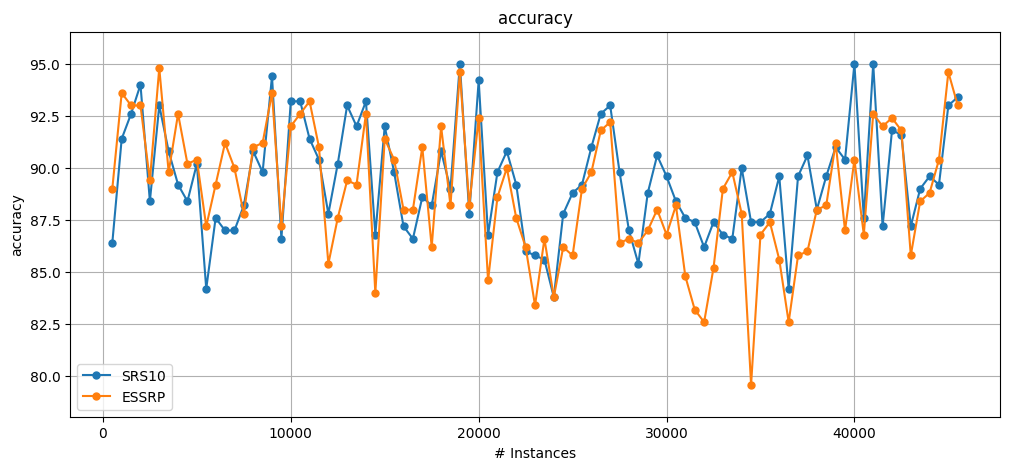

In [ ]:
from capymoa.evaluation import prequential_evaluation
from capymoa.datasets import Electricity
from capymoa.classifier import StreamingRandomPatches

# Compare with baseline
elect_stream = Electricity()
schema = elect_stream.get_schema()

enhanced_srp = EnhancedStreamingRandomPatches(
    schema=schema,
    ensemble_size=10,
    pruning_threshold=0.6,
    warning_threshold=0.7,
     
)

srs10 = StreamingRandomPatches(
    schema=elec.get_schema(),
    training_method="RandomSubspaces",
    max_features=0.6,
    lambda_param=1.0,
     ,
    ensemble_size=10
)



results_srs10 = prequential_evaluation(learner=srs10, stream=elec, window_size=500, max_instances=-1)
results_srs10.learner='SRS10'

ESSRP = prequential_evaluation(learner=enhanced_srp, stream=elec, window_size=500, max_instances=-1)
ESSRP.learner='ESSRP'


print(f'SRS10 acc = {results_srs10.cumulative.accuracy()} wallclock: {results_srs10.wallclock()}')
print(f'SSRP acc = {ESSRP.cumulative.accuracy()} wallclock: {ESSRP.wallclock()}')
# results_srp10, 
plot_windowed_results(results_srs10, ESSRP,  metric="accuracy")

In [ ]:
class EnhancedStreamingRandomPatches(MOAClassifier):
    def __init__(
        self,
        schema: Schema,
        random_seed: int = 1,
        base_learner: str = "trees.HoeffdingTree -g 50 -c 0.01",
        ensemble_size: int = 100,
        initial_pruning_threshold: float = 0.6,
        warning_threshold: float = 0.7,
        max_features: float = 0.6,
        training_method: str = "RandomPatches",
        lambda_param: float = 6.0,
        performance_window: int = 1000,
        calibration_window: int = 500,
        **kwargs
    ):
        # [Keep previous initialization logic]
        
        # New enhancements
        self.calibration_model = HB_toplabel(points_per_bin=50)
        self.calibration_data = deque(maxlen=calibration_window)
        self.drift_detector = ADWIN()
        self.adaptive_pruning = True
        self.diversity_weights = np.ones(ensemble_size)
        self.lambda_param = lambda_param

    def _update_tree_performance(self, instance, predictions):
        # Add instance difficulty weighting
        instance_diff = 1.0 / (1.0 + np.exp(-abs(predictions - actual_label)))
        for i, pred in enumerate(predictions):
            accuracy_update = (1.0 if pred == actual_label else 0.0) * instance_diff
            self.tree_accuracies[i] = 0.97 * self.tree_accuracies[i] + 0.03 * accuracy_update

        # Exponential weighting with diversity factor
        exp_acc = np.exp(self.tree_accuracies - np.max(self.tree_accuracies))
        self.tree_weights = exp_acc / exp_acc.sum() * self.diversity_weights

    def _prune_underperforming_trees(self):
        # Adaptive threshold based on ensemble health
        current_avg = np.mean(self.tree_accuracies)
        adaptive_threshold = max(0.5, current_avg * 0.85)
        
        # Diversity-aware pruning
        pairwise_disagreement = np.mean([
            np.sum(predictions[i] != predictions) 
            for i in range(self.ensemble_size)
        ], axis=1)
        
        to_replace = [
            i for i in range(self.ensemble_size) 
            if (self.tree_accuracies[i] < adaptive_threshold) 
            or (pairwise_disagreement[i] < 0.1 * self.ensemble_size)
        ]
        
        # [Keep replacement logic]

    def _adjust_learning_parameters(self):
        # Dynamic lambda adjustment
        error_rate = 1.0 - np.mean(self.tree_accuracies)
        self.lambda_param = np.clip(6.0 * (1.0 + error_rate), 4.0, 10.0)
        self.moa_learner.setLambda(self.lambda_param)
        
        # [Keep feature subspace adjustment]

    def train(self, instance):
        # Drift detection
        prediction = self.predict(instance)
        self.drift_detector.add_element(1 if prediction != instance.y_index else 0)
        
        if self.drift_detector.detected_change():
            logging.info("Concept drift detected - resetting worst performers")
            worst = np.argsort(self.tree_accuracies)[:10]
            self.tree_accuracies[worst] = 1.0
            
        # [Keep existing training logic]
        
        # Update calibration data
        self.calibration_data.append((self.predict_proba(instance), instance.y_index))
        if len(self.calibration_data) >= 500:
            scores, labels = zip(*self.calibration_data)
            self.calibration_model.fit(np.array(scores), np.array(labels))

    def predict_proba(self, instance):
        # Calibrated predictions
        raw_probas = super().predict_proba(instance)
        if self.calibration_model.fitted:
            return self.calibration_model.predict_proba(raw_probas)
        return raw_probas

    def _calculate_diversity(self):
        # Track prediction diversity across ensemble
        sample_predictions = np.array([
            self.moa_learner.getMember(i).classifyInstance(self.recent_instance)
            for i in range(self.ensemble_size)
        ])
        self.diversity_weights = 1.0 / (1e-5 + np.bincount(sample_predictions))

In [28]:
import numpy as np
from collections import deque
import logging
from capymoa.base import MOAClassifier
from capymoa.stream import Schema
from capymoa._utils import build_cli_str_from_mapping_and_locals
from moa.classifiers.meta import StreamingRandomPatches as _MOA_SRP
from moa.classifiers.core.driftdetection import ADWIN

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

class HB_toplabel:
    def __init__(self, points_per_bin=50):
        self.points_per_bin = points_per_bin
        self.calibration_models = {}
        self.classes = None
        
    def fit(self, pred_mat, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            cls_indices = np.argmax(pred_mat, axis=1) == cls
            if np.sum(cls_indices) >= self.points_per_bin:
                top_scores = pred_mat[cls_indices, cls]
                self.calibration_models[cls] = HB_binary(n_bins=int(np.sum(cls_indices)/self.points_per_bin))
                self.calibration_models[cls].fit(top_scores, y[cls_indices] == cls)
                
    def predict_proba(self, pred_mat):
        calibrated = np.zeros_like(pred_mat)
        for cls in self.classes:
            if cls in self.calibration_models:
                cls_scores = pred_mat[:, cls]
                calibrated[:, cls] = self.calibration_models[cls].predict_proba(cls_scores)
        return calibrated / np.sum(calibrated, axis=1, keepdims=True)

class HB_binary:
    def __init__(self, n_bins=15):
        self.n_bins = n_bins
        self.bin_edges = None
        self.bin_values = None
        
    def fit(self, scores, y):
        order = np.argsort(scores)
        scores_sorted = scores[order]
        y_sorted = y[order]
        self.bin_edges = np.array([np.percentile(scores_sorted, 100*i/self.n_bins) 
                                 for i in range(1, self.n_bins)])
        bin_assign = np.searchsorted(self.bin_edges, scores_sorted)
        self.bin_values = [np.mean(y_sorted[bin_assign == i]) 
                         for i in range(self.n_bins)]
        
    def predict_proba(self, scores):
        bin_assign = np.searchsorted(self.bin_edges, scores)
        return np.array([self.bin_values[min(b, len(self.bin_values)-1)] 
                       for b in bin_assign])

class CalibratedWeightedSRP(MOAClassifier):
    def __init__(
        self,
        schema: Schema,
        base_learner: str = "trees.HoeffdingTree -g 50 -c 0.01",
        ensemble_size: int = 100,
        calibration_window: int = 1000,
        diversity_weight: float = 0.3,
        drift_alpha: float = 0.001,
        training_method: str = "RandomPatches",
        max_features: float = 0.6,
        random_seed: int = 1,
        lambda_param: float = 6.0,
        **kwargs
    ):
        # Initialize MOA SRP
        mapping = {
            "base_learner": "-l",
            "ensemble_size": "-s",
            "feature_mode": "-o",
            "max_features_per_ensemble_item": "-m",
            "training_method_str": "-t",
            "lambda_param": "-a",
        }
        # Handle training method mapping
        training_method_map = {
            "RandomSubspaces": "Random Subspaces",
            "Resampling": "Resampling (bagging)",
            "RandomPatches": "Random Patches",
        }
        assert training_method in training_method_map, "Invalid training method"
        training_method_str = training_method_map[training_method]

        # Handle max features configuration
        if isinstance(max_features, float):
            feature_mode = "Percentage (M * (m / 100))"
            max_features_per_ensemble_item = int(max_features * 100)
        elif max_features == "sqrt":
            feature_mode = "sqrt(M)+1"
            max_features_per_ensemble_item = -1
        else:
            raise ValueError("Invalid max_features value")

        config_str = build_cli_str_from_mapping_and_locals(mapping, locals())
        
        super().__init__(
            moa_learner=_MOA_SRP,
            schema=schema,
            CLI=config_str,
            random_seed=random_seed,
            **kwargs
        )
        
        # Calibration setup
        self.calibrator = HB_toplabel()
        self.calibration_data = deque(maxlen=calibration_window)
        
        # Weight management
        self.accuracies = np.ones(ensemble_size)
        self.diversities = np.ones(ensemble_size)
        self.weights = np.ones(ensemble_size)
        self.diversity_weight = diversity_weight
        
        # Drift detection
        self.drift_detector = ADWIN(drift_alpha)
        self.replacement_size = int(0.1 * ensemble_size)
        
        # State tracking
        self.instance_count = 0
        self.last_predictions = np.zeros((ensemble_size, calibration_window))

    def _update_weights(self):
        """Update ensemble weights combining accuracy and diversity"""
        # Calculate normalized metrics
        norm_acc = self.accuracies / np.sum(self.accuracies)
        norm_div = self.diversities / np.sum(self.diversities)
        
        # Combine with diversity weight
        self.weights = (norm_acc * (1 - self.diversity_weight) + 
                       norm_div * self.diversity_weight)
        self.weights /= np.sum(self.weights)

    def _update_diversity(self, predictions):
        """Update diversity scores using pairwise disagreement"""
        ensemble_consensus = np.argmax(np.bincount(predictions))
        disagreements = predictions != ensemble_consensus
        self.diversities = 0.9 * self.diversities + 0.1 * disagreements
        
        # Update long-term disagreement matrix
        self.last_predictions[:, self.instance_count % len(self.last_predictions[0])] = predictions

    def _calculate_brier_score(self, tree_idx):
        """Calculate calibration quality for a tree"""
        if len(self.calibration_data) < 100:
            return 0.0
            
        probs = np.array([p[tree_idx] for p, _ in self.calibration_data])
        truths = np.array([int(t == np.argmax(p[tree_idx])) for p, t in self.calibration_data])
        return np.mean((probs - truths)**2)

    def train(self, instance):
        # Get pre-update predictions
        predictions = []
        for i in range(self.ensemble_size):
            tree = self.moa_learner.getMember(i)
            pred = tree.classifyInstance(instance.java_instance)
            predictions.append(pred)
            
            # Update accuracy tracking
            correct = 1.0 if pred == instance.y_index else 0.0
            self.accuracies[i] = 0.95 * self.accuracies[i] + 0.05 * correct
        
        # Update calibration data
        probas = np.array([self.moa_learner.getMember(i).getVotesForInstance(instance.java_instance)
                          for i in range(self.ensemble_size)])
        self.calibration_data.append((probas, instance.y_index))
        
        # Update diversity metrics
        self._update_diversity(np.array(predictions))
        
        # Update weights every 100 instances
        if self.instance_count % 100 == 0:
            self._update_weights()
            
            # Update calibrator if enough data
            if len(self.calibration_data) >= 500:
                probas, truths = zip(*self.calibration_data)
                self.calibrator.fit(np.array(probas), np.array(truths))
        
        # Handle concept drift
        self.drift_detector.add_element(1 if np.argmax(self.predict_proba(instance)) != instance.y_index else 0)
        if self.drift_detector.detected_change():
            logging.info("Concept drift detected - replacing underperforming trees")
            worst = np.argsort(self.weights)[:self.replacement_size]
            for idx in worst:
                new_tree = self.moa_learner.newTree()
                new_tree.resetLearning()
                self.moa_learner.setMember(idx, new_tree)
                self.accuracies[idx] = 1.0
                self.diversities[idx] = 1.0
        
        # Train base model
        super().train(instance)
        self.instance_count += 1

    def predict_proba(self, instance):
        # Get raw probabilities
        raw_probas = np.array([self.moa_learner.getMember(i).getVotesForInstance(instance.java_instance)
                              for i in range(self.ensemble_size)])
        
        # Apply calibration
        if self.calibrator.classes is not None:
            calibrated = self.calibrator.predict_proba(raw_probas)
        else:
            calibrated = raw_probas
        
        # Apply weighted voting
        weighted = np.sum(calibrated * self.weights[:, np.newaxis], axis=0)
        return weighted / np.sum(weighted)

    def get_ensemble_metrics(self):
        """Return current ensemble status"""
        return {
            "avg_accuracy": np.mean(self.accuracies),
            "avg_diversity": np.mean(self.diversities),
            "calibration_samples": len(self.calibration_data),
            "active_weights": np.sum(self.weights > 0.01)
        }

In [ ]:
from capymoa.evaluation import prequential_evaluation
from capymoa.datasets import Electricity
from capymoa.classifier import StreamingRandomPatches
from capymoa.evaluation.visualization import plot_windowed_results

# Initialize stream and schema
elec = Electricity()
schema = elec.get_schema()

# --- Baseline Model ---
srs10 = StreamingRandomPatches(
    schema=schema,
    training_method="RandomSubspaces",
    max_features=0.6,
    lambda_param=1.0,
     ,
    ensemble_size=10
)

# --- Calibrated Weighted SRP ---
cw_srp = CalibratedWeightedSRP(
    schema=schema,
    ensemble_size=10,
    calibration_window=500,  # Match evaluation window size
    diversity_weight=0.4,    # Balance between accuracy/diversity
    base_learner="trees.HoeffdingTree -g 50 -c 0.01",  # Match baseline config
     
)

# --- Evaluation ---
results_srs10 = prequential_evaluation(
    learner=srs10, 
    stream=elec, 
    window_size=500, 
    max_instances=-1
)
results_srs10.learner = 'SRS10'

results_cwsrp = prequential_evaluation(
    learner=cw_srp, 
    stream=elec, 
    window_size=500, 
    max_instances=-1
)
results_cwsrp.learner = 'CW-SRP'

# --- Results ---
print(f'SRS10 Accuracy: {results_srs10.cumulative.accuracy():.2%} | '
      f'Wallclock: {results_srs10.wallclock():.1f}s')
print(f'CW-SRP Accuracy: {results_cwsrp.cumulative.accuracy():.2%} | '
      f'Wallclock: {results_cwsrp.wallclock():.1f}s')

# --- Visualization ---
plot_windowed_results(
    results_srs10, 
    results_cwsrp,  
    metric="accuracy"
)

SRS10 Accuracy: 8940.02% | Wallclock: 4.2s
CW-SRP Accuracy: 8881.97% | Wallclock: 12.2s


TypeError: plot_windowed_results() got an unexpected keyword argument 'title'

In [ ]:
from capymoa.classifier import StreamingRandomPatches
from capymoa.evaluation import prequential_evaluation
from capymoa.datasets import Electricity
from capymoa.evaluation.visualization import plot_windowed_results

elec = Electricity()

srs10 = StreamingRandomPatches(
    schema=elec.get_schema(),
    training_method="RandomSubspaces",
    max_features=0.6,
    lambda_param=1.0,
     ,
    ensemble_size=10
)



results_srs10 = prequential_evaluation(learner=srs10, stream=elec, window_size=450, max_instances=-1)
results_srs10.learner='SRS10'



print(f'SRS10 acc = {results_srs10.cumulative.accuracy()} wallclock: {results_srs10.wallclock()}')


# results_srp10, 
plot_windowed_results(results_srs10, xxx, metric="accuracy")

In [4]:
import csv
from capymoa.stream.generator import (
    RandomTreeGenerator,
    SEA,
    HyperPlaneClassification,
    RandomRBFGenerator,
    RandomRBFGeneratorDrift,
    AgrawalGenerator,
    LEDGenerator,
    LEDGeneratorDrift,
    WaveformGenerator,
    WaveformGeneratorDrift,
    STAGGERGenerator,
    SineGenerator,
)
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import StreamingRandomPatches

def evaluate_methods_and_save_csv(csv_filename):
    """
    Evaluate StreamingRandomPatches and StreamWiseRandomPatches on multiple benchmark datasets,
    save results to a CSV file, and plot accuracy.
    """
    datasets = [
        RandomTreeGenerator(),
        SEA(),
        HyperPlaneClassification(),
        RandomRBFGenerator(),
        RandomRBFGeneratorDrift(),
        AgrawalGenerator(),
        LEDGenerator(),
        LEDGeneratorDrift(),
        WaveformGenerator(),
        WaveformGeneratorDrift(),
        STAGGERGenerator(),
        SineGenerator(),
    ]
    
    results = []
    
    for dataset in datasets:
        dataset_name = dataset.__class__.__name__
        print(f"Evaluating on dataset: {dataset_name}")
        
        # Initialize StreamingRandomPatches
        learner_srp = StreamingRandomPatches(
            schema=dataset.get_schema(),
            training_method="RandomSubspaces",
            max_features=0.6,
            lambda_param=1.0,
            random_seed=1,
            ensemble_size=10
        )
        
        # Initialize StreamWiseRandomPatches
        learner_ssrp = StreamWiseRandomPatches(
            schema=dataset.get_schema(),
            random_seed=1,
            ensemble_size=10,
            use_calibration=True,
            calibration_type="HB_toplabel",
            points_per_bin=50,
            sliding_window_size=1000,
            calibration_update_interval=100,
            accuracy_threshold=0.6,
            prune_threshold=0.5
        )
        
        try:
            # Evaluate StreamingRandomPatches
            results_srp = prequential_evaluation(learner=learner_srp, stream=dataset, window_size=450, max_instances=100_00)
            results_srp.learner = "StreamingRandomPatches"
            
            # Evaluate StreamWiseRandomPatches
            results_ssrp = prequential_evaluation(learner=learner_ssrp, stream=dataset, window_size=450, max_instances=100_00)
            results_ssrp.learner = "StreamWiseRandomPatches"
            
            # Append results to the list
            results.append({"Dataset": dataset_name, "Classifier": "StreamingRandomPatches", "Accuracy": results_srp.cumulative.accuracy()})
            results.append({"Dataset": dataset_name, "Classifier": "StreamWiseRandomPatches", "Accuracy": results_ssrp.cumulative.accuracy()})
            
            print(f"Dataset: {dataset_name} | StreamingRandomPatches Accuracy: {results_srp.cumulative.accuracy():.2f} | StreamWiseRandomPatches Accuracy: {results_ssrp.cumulative.accuracy():.2f}")
            
        except Exception as e:
            print(f"Error during evaluation on dataset {dataset_name}: {e}")
    
    # Save results to CSV
    with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["Dataset", "Classifier", "Accuracy"])
        writer.writeheader()
        writer.writerows(results)
    
    print(f"Results saved to {csv_filename}")

evaluate_methods_and_save_csv("HEITORCorrect_logic.csv")


Evaluating on dataset: RandomTreeGenerator
Dataset: RandomTreeGenerator | StreamingRandomPatches Accuracy: 83.84 | StreamWiseRandomPatches Accuracy: 82.74
Evaluating on dataset: SEA
Dataset: SEA | StreamingRandomPatches Accuracy: 86.68 | StreamWiseRandomPatches Accuracy: 88.30
Evaluating on dataset: HyperPlaneClassification
Dataset: HyperPlaneClassification | StreamingRandomPatches Accuracy: 82.90 | StreamWiseRandomPatches Accuracy: 87.49
Evaluating on dataset: RandomRBFGenerator
Dataset: RandomRBFGenerator | StreamingRandomPatches Accuracy: 82.43 | StreamWiseRandomPatches Accuracy: 91.19
Evaluating on dataset: RandomRBFGeneratorDrift
Dataset: RandomRBFGeneratorDrift | StreamingRandomPatches Accuracy: 82.43 | StreamWiseRandomPatches Accuracy: 91.19
Evaluating on dataset: AgrawalGenerator
Dataset: AgrawalGenerator | StreamingRandomPatches Accuracy: 93.77 | StreamWiseRandomPatches Accuracy: 91.74
Evaluating on dataset: LEDGenerator
Dataset: LEDGenerator | StreamingRandomPatches Accuracy:

In [5]:
import csv
from capymoa.stream.generator import (
    RandomTreeGenerator,
    SEA,
    HyperPlaneClassification,
    RandomRBFGenerator,
    RandomRBFGeneratorDrift,
    AgrawalGenerator,
    LEDGenerator,
    LEDGeneratorDrift,
    WaveformGenerator,
    WaveformGeneratorDrift,
    STAGGERGenerator,
    SineGenerator,
)
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import StreamingRandomPatches

def evaluate_methods_and_save_csv(csv_filename):
    """
    Evaluate StreamingRandomPatches and StreamWiseRandomPatches on multiple benchmark datasets,
    save results to a CSV file, and plot accuracy.
    """
    datasets = [
        RandomTreeGenerator(),
        SEA(),
        HyperPlaneClassification(),
        RandomRBFGenerator(),
        RandomRBFGeneratorDrift(),
        AgrawalGenerator(),
        LEDGenerator(),
        LEDGeneratorDrift(),
        WaveformGenerator(),
        WaveformGeneratorDrift(),
        STAGGERGenerator(),
        SineGenerator(),
    ]
    
    results = []
    
    for dataset in datasets:
        dataset_name = dataset.__class__.__name__
        print(f"Evaluating on dataset: {dataset_name}")
        
        # Initialize StreamingRandomPatches
        learner_srp = StreamingRandomPatches(
            schema=dataset.get_schema(),
            training_method="RandomSubspaces",
            max_features=0.6,
            lambda_param=1.0,
            random_seed=1,
            ensemble_size=100
        )
        
        # Initialize StreamWiseRandomPatches
        learner_ssrp = StreamWiseRandomPatches(
            schema=dataset.get_schema(),
            random_seed=1,
            ensemble_size=100,
            use_calibration=True,
            calibration_type="HB_toplabel",
            points_per_bin=50,
            sliding_window_size=1000,
            calibration_update_interval=100,
            accuracy_threshold=0.6,
            prune_threshold=0.5
        )
        
        try:
            # Evaluate StreamingRandomPatches
            results_srp = prequential_evaluation(learner=learner_srp, stream=dataset, window_size=450, max_instances=100_00)
            results_srp.learner = "StreamingRandomPatches"
            
            # Evaluate StreamWiseRandomPatches
            results_ssrp = prequential_evaluation(learner=learner_ssrp, stream=dataset, window_size=450, max_instances=100_00)
            results_ssrp.learner = "StreamWiseRandomPatches"
            
            # Append results to the list
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamingRandomPatches",
                "Accuracy": results_srp.cumulative.accuracy(),
                "Wallclock": results_srp.wallclock()
            })
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamWiseRandomPatches",
                "Accuracy": results_ssrp.cumulative.accuracy(),
                "Wallclock": results_ssrp.wallclock()
            })
            
            print(f"Dataset: {dataset_name} | StreamingRandomPatches Accuracy: {results_srp.cumulative.accuracy():.2f} | StreamWiseRandomPatches Accuracy: {results_ssrp.cumulative.accuracy():.2f}")
            
        except Exception as e:
            print(f"Error during evaluation on dataset {dataset_name}: {e}")
    
    # Save results to CSV
    with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["Dataset", "Classifier", "Accuracy", "Wallclock"])
        writer.writeheader()
        writer.writerows(results)
    
    print(f"Results saved to {csv_filename}")

evaluate_methods_and_save_csv("HEITORtime100Correct_logic.csv")


Evaluating on dataset: RandomTreeGenerator
Dataset: RandomTreeGenerator | StreamingRandomPatches Accuracy: 82.91 | StreamWiseRandomPatches Accuracy: 82.74
Evaluating on dataset: SEA
Dataset: SEA | StreamingRandomPatches Accuracy: 86.43 | StreamWiseRandomPatches Accuracy: 88.30
Evaluating on dataset: HyperPlaneClassification
Dataset: HyperPlaneClassification | StreamingRandomPatches Accuracy: 88.15 | StreamWiseRandomPatches Accuracy: 87.49
Evaluating on dataset: RandomRBFGenerator
Dataset: RandomRBFGenerator | StreamingRandomPatches Accuracy: 84.07 | StreamWiseRandomPatches Accuracy: 91.19
Evaluating on dataset: RandomRBFGeneratorDrift
Dataset: RandomRBFGeneratorDrift | StreamingRandomPatches Accuracy: 84.07 | StreamWiseRandomPatches Accuracy: 91.19
Evaluating on dataset: AgrawalGenerator
Dataset: AgrawalGenerator | StreamingRandomPatches Accuracy: 93.90 | StreamWiseRandomPatches Accuracy: 91.74
Evaluating on dataset: LEDGenerator
Dataset: LEDGenerator | StreamingRandomPatches Accuracy:

In [6]:
import csv
from capymoa.stream.generator import (
    RandomTreeGenerator,
    SEA,
    HyperPlaneClassification,
    RandomRBFGenerator,
    RandomRBFGeneratorDrift,
    AgrawalGenerator,
    LEDGenerator,
    LEDGeneratorDrift,
    WaveformGenerator,
    WaveformGeneratorDrift,
    STAGGERGenerator,
    SineGenerator,
)
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import StreamingRandomPatches

def evaluate_methods_and_save_csv(csv_filename):
    """
    Evaluate StreamingRandomPatches and StreamWiseRandomPatches on multiple benchmark datasets,
    save results to a CSV file, and plot accuracy.
    """
    datasets = [
        RandomTreeGenerator(),
        SEA(),
        HyperPlaneClassification(),
        RandomRBFGenerator(),
        RandomRBFGeneratorDrift(),
        AgrawalGenerator(),
        LEDGenerator(),
        LEDGeneratorDrift(),
        WaveformGenerator(),
        WaveformGeneratorDrift(),
        STAGGERGenerator(),
        SineGenerator(),
    ]
    
    results = []
    
    for dataset in datasets:
        dataset_name = dataset.__class__.__name__
        print(f"Evaluating on dataset: {dataset_name}")
        
        # Initialize StreamingRandomPatches
        learner_srp = StreamingRandomPatches(
            schema=dataset.get_schema(),
            training_method="RandomSubspaces",
            max_features=0.6,
            lambda_param=1.0,
            random_seed=1,
            ensemble_size=100
        )
        
        # Initialize StreamWiseRandomPatches
        learner_ssrp = StreamWiseRandomPatches(
            schema=dataset.get_schema(),
            random_seed=1,
            ensemble_size=100,
            use_calibration=True,
            calibration_type="HB_toplabel",
            points_per_bin=50,
            sliding_window_size=1000,
            calibration_update_interval=100,
            accuracy_threshold=0.6,
            prune_threshold=0.5
        )
        
        try:
            # Evaluate StreamingRandomPatches
            results_srp = prequential_evaluation(learner=learner_srp, stream=dataset, window_size=450, max_instances=100000)
            results_srp.learner = "StreamingRandomPatches"
            
            # Evaluate StreamWiseRandomPatches
            results_ssrp = prequential_evaluation(learner=learner_ssrp, stream=dataset, window_size=450, max_instances=100000)
            results_ssrp.learner = "StreamWiseRandomPatches"
            
            # Append results to the list
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamingRandomPatches",
                "Accuracy": results_srp.cumulative.accuracy(),
                "Wallclock": results_srp.wallclock()
            })
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamWiseRandomPatches",
                "Accuracy": results_ssrp.cumulative.accuracy(),
                "Wallclock": results_ssrp.wallclock()
            })
            
            print(f"Dataset: {dataset_name} | StreamingRandomPatches Accuracy: {results_srp.cumulative.accuracy():.2f} | StreamWiseRandomPatches Accuracy: {results_ssrp.cumulative.accuracy():.2f}")
            
        except Exception as e:
            print(f"Error during evaluation on dataset {dataset_name}: {e}")
    
    # Save results to CSV
    with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["Dataset", "Classifier", "Accuracy", "Wallclock"])
        writer.writeheader()
        writer.writerows(results)
    
    print(f"Results saved to {csv_filename}")

evaluate_methods_and_save_csv("HEITORtime100_1000000Correct_logic.csv")


Evaluating on dataset: RandomTreeGenerator
Dataset: RandomTreeGenerator | StreamingRandomPatches Accuracy: 87.79 | StreamWiseRandomPatches Accuracy: 88.75
Evaluating on dataset: SEA
Dataset: SEA | StreamingRandomPatches Accuracy: 88.68 | StreamWiseRandomPatches Accuracy: 89.39
Evaluating on dataset: HyperPlaneClassification
Dataset: HyperPlaneClassification | StreamingRandomPatches Accuracy: 90.01 | StreamWiseRandomPatches Accuracy: 89.56
Evaluating on dataset: RandomRBFGenerator
Dataset: RandomRBFGenerator | StreamingRandomPatches Accuracy: 92.56 | StreamWiseRandomPatches Accuracy: 93.79
Evaluating on dataset: RandomRBFGeneratorDrift
Dataset: RandomRBFGeneratorDrift | StreamingRandomPatches Accuracy: 92.56 | StreamWiseRandomPatches Accuracy: 93.79
Evaluating on dataset: AgrawalGenerator
Dataset: AgrawalGenerator | StreamingRandomPatches Accuracy: 94.79 | StreamWiseRandomPatches Accuracy: 94.36
Evaluating on dataset: LEDGenerator
Dataset: LEDGenerator | StreamingRandomPatches Accuracy:

In [9]:
import csv
from capymoa.stream import ARFFStream
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import StreamingRandomPatches

def evaluate_methods_and_save_csv(csv_filename):
    """
    Evaluate StreamingRandomPatches and StreamWiseRandomPatches on multiple benchmark datasets,
    save results to a CSV file, and plot accuracy.
    """
    datasets = [
    ARFFStream(path="./data/airlines.arff", class_index=-1),
    ARFFStream(path="./data/electricity.arff", class_index=-1),
    ARFFStream(path="./data/internet_ads.arff", class_index=-1),
    ARFFStream(path="./data/covtype.arff", class_index=-1),
    ARFFStream(path="./data/kdd99.arff", class_index=-1),
]
    
    results = []
    
    for dataset in datasets:
        dataset_name = dataset.__class__.__name__
        print(f"Evaluating on dataset: {dataset_name}")
        
        # Initialize StreamingRandomPatches
        learner_srp = StreamingRandomPatches(
            schema=dataset.get_schema(),
            training_method="RandomSubspaces",
            max_features=0.6,
            lambda_param=1.0,
            random_seed=1,
            ensemble_size=100
        )
        
        # Initialize StreamWiseRandomPatches
        learner_ssrp = StreamWiseRandomPatches(
            schema=dataset.get_schema(),
            random_seed=1,
            ensemble_size=100,
            use_calibration=True,
            calibration_type="HB_toplabel",
            points_per_bin=50,
            sliding_window_size=1000,
            calibration_update_interval=100,
            accuracy_threshold=0.6,
            prune_threshold=0.5
        )
        
        try:
            # Evaluate StreamingRandomPatches
            results_srp = prequential_evaluation(learner=learner_srp, stream=dataset, window_size=450, max_instances=-1)
            results_srp.learner = "StreamingRandomPatches"
            
            # Evaluate StreamWiseRandomPatches
            results_ssrp = prequential_evaluation(learner=learner_ssrp, stream=dataset, window_size=450, max_instances=-1)
            results_ssrp.learner = "StreamWiseRandomPatches"
            
            # Append results to the list
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamingRandomPatches",
                "Accuracy": results_srp.cumulative.accuracy(),
                "Wallclock": results_srp.wallclock()
            })
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamWiseRandomPatches",
                "Accuracy": results_ssrp.cumulative.accuracy(),
                "Wallclock": results_ssrp.wallclock()
            })
            
            print(f"Dataset: {dataset_name} | StreamingRandomPatches Accuracy: {results_srp.cumulative.accuracy():.2f} | StreamWiseRandomPatches Accuracy: {results_ssrp.cumulative.accuracy():.2f}")
            
        except Exception as e:
            print(f"Error during evaluation on dataset {dataset_name}: {e}")
    
    # Save results to CSV
    with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["Dataset", "Classifier", "Accuracy", "Wallclock"])
        writer.writeheader()
        writer.writerows(results)
    
    print(f"Results saved to {csv_filename}")

evaluate_methods_and_save_csv("HEITORtimeREAL_100Correct_logic.csv")


Evaluating on dataset: ARFFStream
Dataset: ARFFStream | StreamingRandomPatches Accuracy: 68.28 | StreamWiseRandomPatches Accuracy: 68.57
Evaluating on dataset: ARFFStream
Dataset: ARFFStream | StreamingRandomPatches Accuracy: 90.27 | StreamWiseRandomPatches Accuracy: 89.86
Evaluating on dataset: ARFFStream
Dataset: ARFFStream | StreamingRandomPatches Accuracy: 99.70 | StreamWiseRandomPatches Accuracy: 99.94
Evaluating on dataset: ARFFStream
Dataset: ARFFStream | StreamingRandomPatches Accuracy: 93.33 | StreamWiseRandomPatches Accuracy: 95.33
Evaluating on dataset: ARFFStream
Dataset: ARFFStream | StreamingRandomPatches Accuracy: 99.97 | StreamWiseRandomPatches Accuracy: 99.98
Results saved to HEITORtimeREAL_100Correct_logic.csv


In [10]:
import csv
from capymoa.stream import ARFFStream
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import StreamingRandomPatches
from capymoa.classifier import StreamingGradientBoostedTrees

def evaluate_methods_and_save_csv(csv_filename):
    """
    Evaluate StreamingRandomPatches and StreamWiseRandomPatches on multiple benchmark datasets,
    save results to a CSV file, and plot accuracy.
    """
    datasets = [
    ARFFStream(path="./data/airlines.arff", class_index=-1),
    ARFFStream(path="./data/electricity.arff", class_index=-1),
    ARFFStream(path="./data/internet_ads.arff", class_index=-1),
    ARFFStream(path="./data/covtype.arff", class_index=-1),
    ARFFStream(path="./data/kdd99.arff", class_index=-1),
]
    
    results = []
    
    for dataset in datasets:
        dataset_name = dataset.__class__.__name__
        print(f"Evaluating on dataset: {dataset_name}")
        
        # Initialize StreamingRandomPatches
        learner_srp = StreamingRandomPatches(
            schema=dataset.get_schema(),
            training_method="RandomSubspaces",
            max_features=0.6,
            lambda_param=1.0,
            random_seed=1,
            ensemble_size=100
        )
        
        # Initialize StreamWiseRandomPatches
        learner_ssrp = StreamWiseRandomPatches(
            schema=dataset.get_schema(),
            random_seed=1,
            ensemble_size=100,
            use_calibration=True,
            calibration_type="HB_toplabel",
            points_per_bin=50,
            sliding_window_size=1000,
            calibration_update_interval=100,
            accuracy_threshold=0.6,
            prune_threshold=0.5
        )

        learner_sgbt = StreamingGradientBoostedTrees(
            schema=dataset.get_schema(),
            random_seed = 0,
            base_learner="trees.FIMTDD -s VarianceReductionSplitCriterion -g 25 -c 0.05 -e -p",
            boosting_iterations = 100,
            percentage_of_features = 75,
            learning_rate=0.0125,
            disable_one_hot = False,
            multiply_hessian_by= 1,
            skip_training = 1,
            use_squared_loss = False)

        
        try:
            # Evaluate StreamingRandomPatches
            results_srp = prequential_evaluation(learner=learner_srp, stream=dataset, window_size=450, max_instances=-1)
            results_srp.learner = "StreamingRandomPatches"
            
            # Evaluate StreamWiseRandomPatches
            results_ssrp = prequential_evaluation(learner=learner_ssrp, stream=dataset, window_size=450, max_instances=-1)
            results_ssrp.learner = "StreamWiseRandomPatches"
            
            results_sgbt = prequential_evaluation(learner=learner_sgbt, stream=dataset, window_size=450, max_instances=-1)
            results_sgbt.learner = "StreamingGradientBoostedTrees"

            # Append results to the list
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamingRandomPatches",
                "Accuracy": results_srp.cumulative.accuracy(),
                "Wallclock": results_srp.wallclock()
            })
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamWiseRandomPatches",
                "Accuracy": results_ssrp.cumulative.accuracy(),
                "Wallclock": results_ssrp.wallclock()
            })
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamingGradientBoostedTrees",
                "Accuracy": results_sgbt.cumulative.accuracy(),
                "Wallclock": results_sgbt.wallclock()
            })
            
            print(f"Dataset: {dataset_name} | StreamingRandomPatches Accuracy: {results_srp.cumulative.accuracy():.2f} | StreamWiseRandomPatches Accuracy: {results_ssrp.cumulative.accuracy():.2f} | StreamingGradientBoostedTrees Accuracy: {results_sgbt.cumulative.accuracy():.2f}")
            
        except Exception as e:
            print(f"Error during evaluation on dataset {dataset_name}: {e}")
    
    # Save results to CSV
    with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["Dataset", "Classifier", "Accuracy", "Wallclock"])
        writer.writeheader()
        writer.writerows(results)
    
    print(f"Results saved to {csv_filename}")

evaluate_methods_and_save_csv("SGBTHEITORtimeREAL_100Correct_logic.csv")


Evaluating on dataset: ARFFStream


: 

In [ ]:
import csv
from capymoa.stream import ARFFStream
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import StreamingRandomPatches
from capymoa.classifier import StreamingGradientBoostedTrees

def evaluate_methods_and_save_csv(csv_filename):
    """
    Evaluate StreamingRandomPatches and StreamWiseRandomPatches on multiple benchmark datasets,
    save results to a CSV file, and plot accuracy.
    """
    datasets = [
        RandomTreeGenerator(),
        SEA(),
        HyperPlaneClassification(),
        RandomRBFGenerator(),
        RandomRBFGeneratorDrift(),
        AgrawalGenerator(),
        LEDGenerator(),
        LEDGeneratorDrift(),
        WaveformGenerator(),
        WaveformGeneratorDrift(),
        STAGGERGenerator(),
        SineGenerator(),
    ]
    
    results = []
    
    for dataset in datasets:
        dataset_name = dataset.__class__.__name__
        print(f"Evaluating on dataset: {dataset_name}")
        
        # Initialize StreamingRandomPatches
        learner_srp = StreamingRandomPatches(
            schema=dataset.get_schema(),
            training_method="RandomSubspaces",
            max_features=0.6,
            lambda_param=1.0,
            random_seed=1,
            ensemble_size=100
        )
        
        # Initialize StreamWiseRandomPatches
        learner_ssrp = StreamWiseRandomPatches(
            schema=dataset.get_schema(),
            random_seed=1,
            ensemble_size=100,
            use_calibration=True,
            calibration_type="HB_toplabel",
            points_per_bin=50,
            sliding_window_size=1000,
            calibration_update_interval=100,
            accuracy_threshold=0.6,
            prune_threshold=0.5
        )

        learner_sgbt = StreamingGradientBoostedTrees(
            schema=dataset.get_schema(),
            random_seed = 0,
            base_learner="trees.FIMTDD -s VarianceReductionSplitCriterion -g 25 -c 0.05 -e -p",
            boosting_iterations = 100,
            percentage_of_features = 75,
            learning_rate=0.0125,
            disable_one_hot = False,
            multiply_hessian_by= 1,
            skip_training = 1,
            use_squared_loss = False)

        
        try:
            # Evaluate StreamingRandomPatches
            results_srp = prequential_evaluation(learner=learner_srp, stream=dataset, window_size=450, max_instances=1000000)
            results_srp.learner = "StreamingRandomPatches"
            
            # Evaluate StreamWiseRandomPatches
            results_ssrp = prequential_evaluation(learner=learner_ssrp, stream=dataset, window_size=450, max_instances=1000000)
            results_ssrp.learner = "StreamWiseRandomPatches"
            
            results_sgbt = prequential_evaluation(learner=learner_sgbt, stream=dataset, window_size=450, max_instances=1000000)
            results_sgbt.learner = "StreamingGradientBoostedTrees"

            # Append results to the list
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamingRandomPatches",
                "Accuracy": results_srp.cumulative.accuracy(),
                "Wallclock": results_srp.wallclock()
            })
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamWiseRandomPatches",
                "Accuracy": results_ssrp.cumulative.accuracy(),
                "Wallclock": results_ssrp.wallclock()
            })
            results.append({
                "Dataset": dataset_name,
                "Classifier": "StreamingGradientBoostedTrees",
                "Accuracy": results_sgbt.cumulative.accuracy(),
                "Wallclock": results_sgbt.wallclock()
            })
            
            print(f"Dataset: {dataset_name} | StreamingRandomPatches Accuracy: {results_srp.cumulative.accuracy():.2f} | StreamWiseRandomPatches Accuracy: {results_ssrp.cumulative.accuracy():.2f} | StreamingGradientBoostedTrees Accuracy: {results_sgbt.cumulative.accuracy():.2f}")
            
        except Exception as e:
            print(f"Error during evaluation on dataset {dataset_name}: {e}")
    
    # Save results to CSV
    with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["Dataset", "Classifier", "Accuracy", "Wallclock"])
        writer.writeheader()
        writer.writerows(results)
    
    print(f"Results saved to {csv_filename}")

evaluate_methods_and_save_csv("REALSGBTHEITORtimeREAL_100Correct_logic.csv")
